# This is fruit classification project implementation #4

**Part1: Reading Data**

In [1]:
import cv2
import glob
import os
import numpy as np # linear algebra
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import random
import math
import matplotlib.image as mpimg
from os.path import join, exists, expanduser

Using TensorFlow backend.


In [2]:
os.chdir("../input/")

!ls *

fruits:
fruits-360_dataset

keras-pretrained-models:
Kuszma.JPG
imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5

realtestdata:
real-data


In [3]:
train_data_dir = '../input/fruits/fruits-360_dataset/fruits-360/Training/'
test_data_dir = '../input/fruits/fruits-360_dataset/fruits-360/Test/'

In [4]:
def read_and_preprocess_img(image_path,img_color,img_size):
    image = cv2.imread(image_path,cv2.IMREAD_COLOR)
    if(img_color == "RGB"):
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    elif(img_color == "Gray"):
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    imResize = cv2.resize(image, dsize=img_size) 
    return imResize.astype("float32")/255

In [5]:
def read_data(path,img_color,img_size):
    data_fruit_img = []
    data_label = []
    for dir_path in glob.glob(path+"/*"):
        img_label = dir_path.split("/")[-1]
        for image_path in glob.glob(os.path.join(dir_path,"*.jpg")):
            image = read_and_preprocess_img(image_path,img_color,img_size)
            data_fruit_img.append(image)
            data_label.append(img_label)
    return (np.array(data_fruit_img),np.array(data_label))

In [6]:
# Read Training data
X_train,train_label = read_data(train_data_dir,"RGB",(100,100))
print(X_train.shape)
print(train_label.shape)

(41322, 100, 100, 3)
(41322,)


**Part2: Reading and augmenting Data with ImageDataGenerator Api**

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=90,
    width_shift_range=.02,
    height_shift_range=.02,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=1.,
    brightness_range=[0.5, 1.5],
    #zoom_range=0.02,
    shear_range = .8,
    validation_split = .25
)

test_datagen = ImageDataGenerator(rescale=1. / 255)
batch_size_train = 128
batch_size_valid = 128

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (100,100),
    #batch_size=batch_size_train,
    class_mode='categorical',
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (100,100),
    #batch_size=batch_size_valid,#default is 32
    class_mode='categorical',
    subset='validation'
)

Found 31018 images belonging to 81 classes.
Found 10304 images belonging to 81 classes.


In [8]:
test_generator = test_datagen.flow_from_directory(
    directory=test_data_dir,
    target_size=(100, 100),
    batch_size=1,
    shuffle = False,
)

Found 13877 images belonging to 81 classes.


In [9]:
!rm -rf /tmp/augmented_data/
models_dir = expanduser(join('~', 'augmented_data')) #directory for saving augmented data
if not exists(models_dir):
    os.makedirs(models_dir)

In [10]:
!rm -rf /tmp/saved_models/
models_dir = expanduser(join('~', 'saved_models'))
if not exists(models_dir):
    os.makedirs(models_dir)

In [11]:
!ls ~

augmented_data	saved_models


**Part3: Visualize augmented data**

In [12]:
# take subset of training data
random_train_sample = np.array(random.sample(list(X_train),  10))

In [13]:
i = 0
for x_batch in train_datagen.flow(random_train_sample, batch_size=1,save_to_dir='/tmp/augmented_data/', save_prefix='aug', save_format='jpeg'):
    i += 1
    if i >= 20:
        break

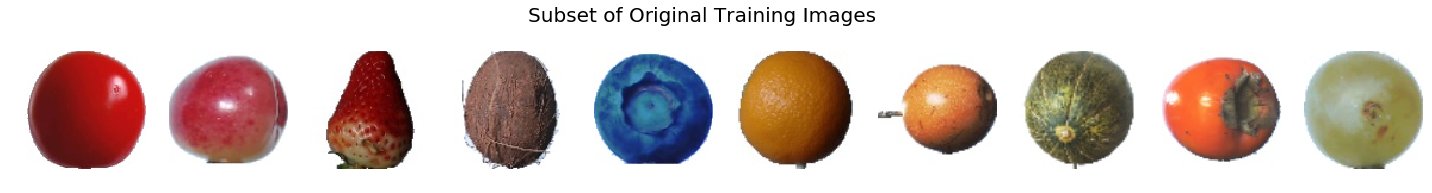

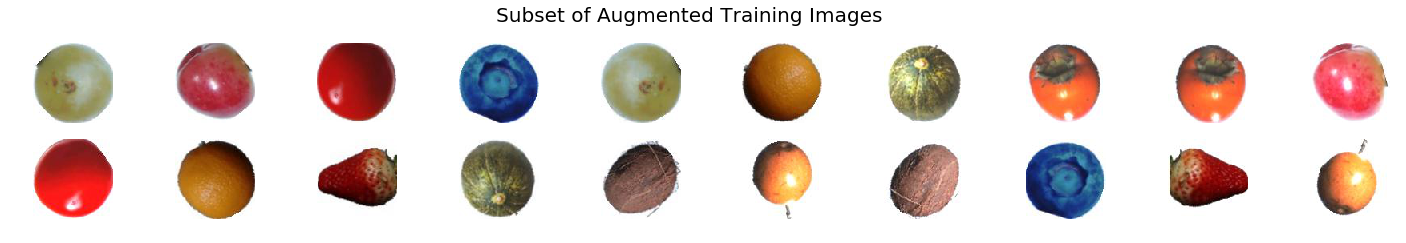

In [14]:
# visualize subset of training data
fig = plt.figure(figsize=(25,3))
for i in range(0, len(random_train_sample)):
    ax = fig.add_subplot(1, 10, i+1)
    ax.axis('off')
    ax.imshow(random_train_sample[i])
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.axis('off')
plt.show()


images = []
for img_path in glob.glob('/tmp/augmented_data/*.jpeg'):
    images.append(mpimg.imread(img_path))
    
fig = plt.figure(figsize=(25, 5))
fig.suptitle('Subset of Augmented Training Images', fontsize=20)

columns = 10
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.axis('off')
    plt.imshow(image)

In [15]:
training_data = pd.DataFrame(train_generator.classes, columns=['classes'])
testing_data = pd.DataFrame(validation_generator.classes, columns=['classes'])

In [16]:
def create_stack_bar_data(col, df):
    aggregated = df[col].value_counts().sort_index()
    x_values = aggregated.index.tolist()
    y_values = aggregated.values.tolist()
    return x_values, y_values

In [17]:
x1, y1 = create_stack_bar_data('classes', training_data)
x1 = list(train_generator.class_indices.keys())

In [18]:
def display_image_in_actual_size(im_path):

    dpi = 80
    im_data = plt.imread(im_path)
    height, width, depth = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

In [19]:
# making default directory for pretrained keras models, since kaggle can't download it online
cache_dir = expanduser(join('~', '.keras')) 
if not exists(cache_dir):
    os.makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    os.makedirs(models_dir)
    
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/
!cp ../input/keras-pretrained-models/resnet50* ~/.keras/models/

print("Available Pretrained Models:\n")
!ls ~/.keras/models

Available Pretrained Models:

imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


**Part4: Building Models and Testing on regular test set**

In [20]:
from keras import applications
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf
from keras.optimizers import SGD
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,LearningRateScheduler

In [21]:
#import xception with pre-trained weights. do not include fully #connected layers
xception_base = applications.Xception(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = xception_base.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
#x = Dense(512, activation='relu')(x)
# and a fully connected output/classification layer
predictions = Dense(81, activation='softmax')(x)
# create the full network so we can train on it
xception_transfer = Model(inputs=xception_base.input, outputs=predictions)
xception_transfer.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

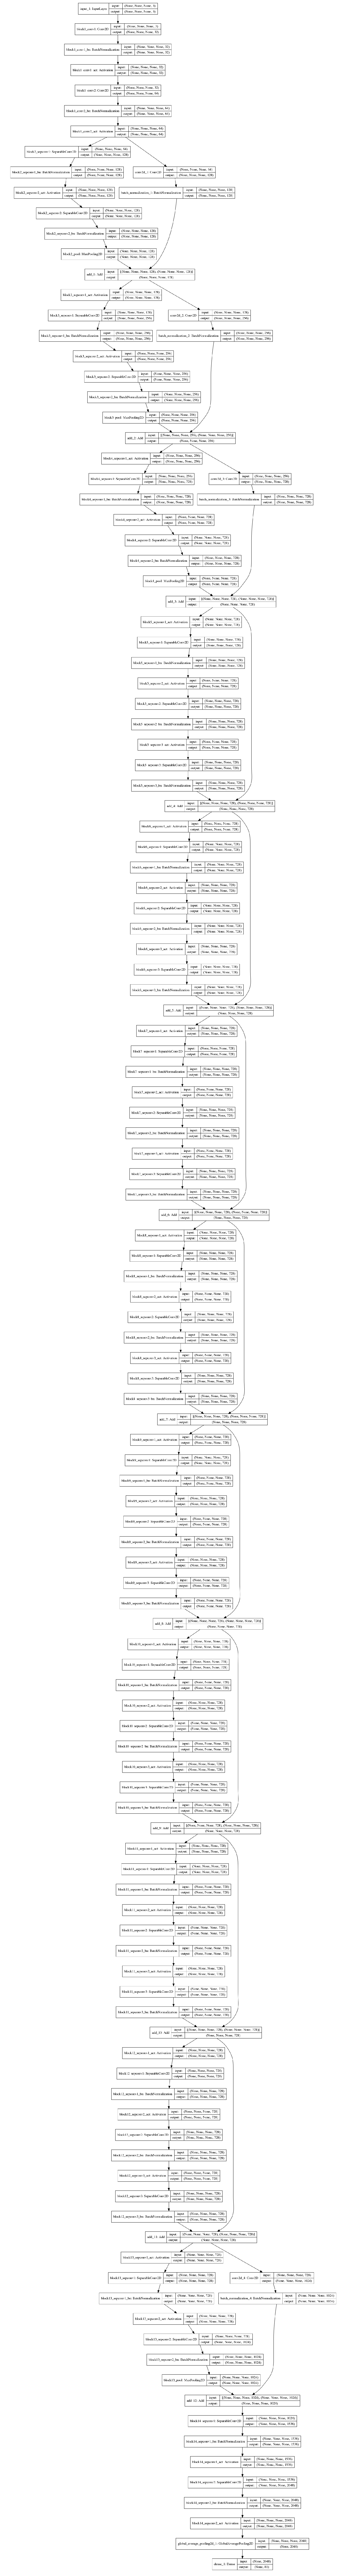

In [22]:
plot_model(xception_transfer, to_file='/tmp/saved_models/xception_pretrained.png', show_shapes=True)
display_image_in_actual_size('/tmp/saved_models/xception_pretrained.png')

In [23]:
#import xception with random weights. do not include fully #connected layers
xception_base_vanilla = applications.Xception(weights=None, include_top=False)

# add a global spatial average pooling layer
x = xception_base_vanilla.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
#x = Dense(512, activation='relu')(x)
# and a fully connected output/classification layer
predictions = Dense(81, activation='softmax')(x)
# create the full network so we can train on it
xception_transfer_vanilla = Model(inputs=xception_base_vanilla.input, outputs=predictions)
xception_transfer_vanilla.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

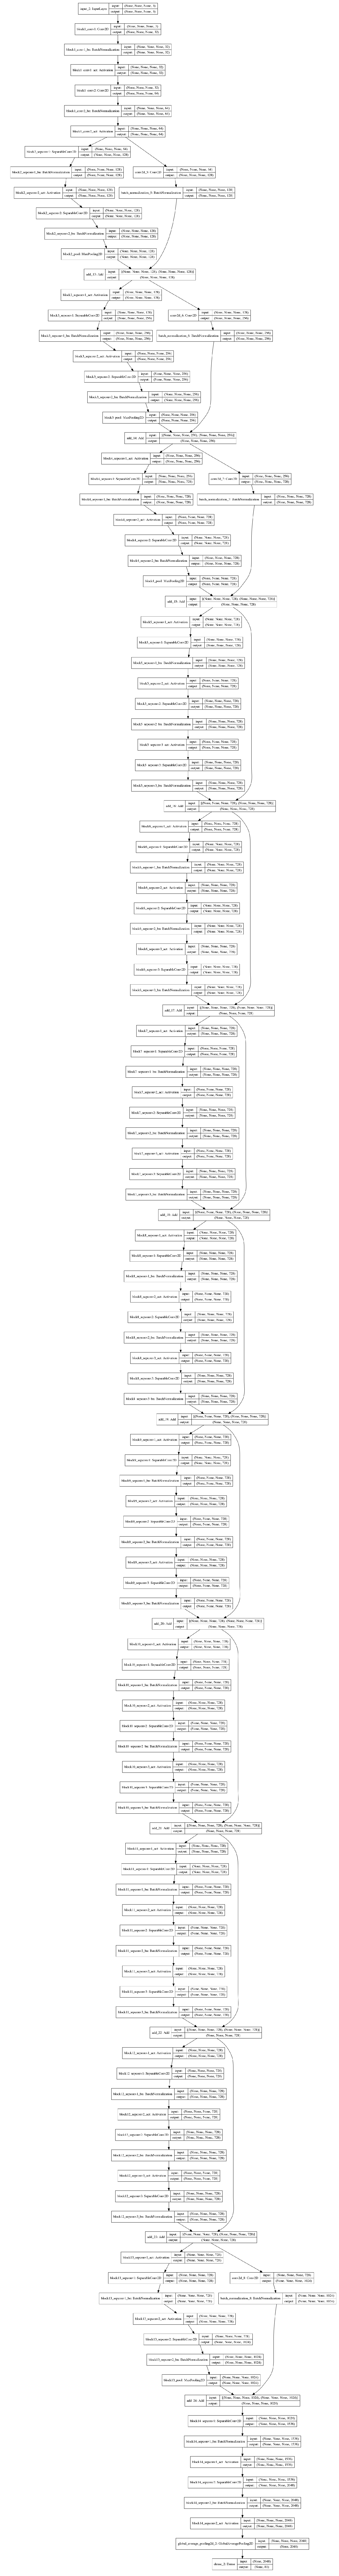

In [24]:
plot_model(xception_transfer_vanilla, to_file='/tmp/saved_models/xception_vanilla.png', show_shapes=True)
display_image_in_actual_size('/tmp/saved_models/xception_vanilla.png')

In [25]:
xception_transfer.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

xception_transfer_vanilla.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [26]:
#listing devices in our environment
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9589856918625926304
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11281304781
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16778757633272319887
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [27]:
checkpointer = ModelCheckpoint(filepath='/tmp/saved_models/weights.best.xception_pretrained.hdf5', 
                               verbose=1, save_best_only=True)
#Early stopping
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=4)

with tf.device("/device:GPU:0"): #running code using gpu
    history_pretrained = xception_transfer.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    callbacks=[checkpointer,early_stopping],
    verbose = 1,
    validation_data = validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size)

Epoch 1/50
969/969 [==============================] - 366s 377ms/step - loss: 0.4634 - acc: 0.8690 - val_loss: 0.4113 - val_acc: 0.8987

Epoch 00001: val_loss improved from inf to 0.41128, saving model to /tmp/saved_models/weights.best.xception_pretrained.hdf5
Epoch 2/50
969/969 [==============================] - 350s 361ms/step - loss: 0.1150 - acc: 0.9630 - val_loss: 0.1602 - val_acc: 0.9447

Epoch 00002: val_loss improved from 0.41128 to 0.16019, saving model to /tmp/saved_models/weights.best.xception_pretrained.hdf5
Epoch 3/50
969/969 [==============================] - 349s 360ms/step - loss: 0.0925 - acc: 0.9685 - val_loss: 0.2405 - val_acc: 0.9417

Epoch 00003: val_loss did not improve from 0.16019
Epoch 4/50
969/969 [==============================] - 348s 359ms/step - loss: 0.0897 - acc: 0.9711 - val_loss: 0.1258 - val_acc: 0.9634

Epoch 00004: val_loss improved from 0.16019 to 0.12576, saving model to /tmp/saved_models/weights.best.xception_pretrained.hdf5
Epoch 5/50
969/969 [=

In [28]:
checkpointer = ModelCheckpoint(filepath='/tmp/saved_models/weights.best.xception_vanilla.hdf5', 
                               verbose=1, save_best_only=True)

import tensorflow as tf
with tf.device("/device:GPU:0"):
    history_vanilla = xception_transfer_vanilla.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    callbacks=[checkpointer,early_stopping],
    verbose = 1,
    validation_data = validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size)

Epoch 1/50
969/969 [==============================] - 361s 373ms/step - loss: 0.9806 - acc: 0.6929 - val_loss: 3.9186 - val_acc: 0.4011

Epoch 00001: val_loss improved from inf to 3.91855, saving model to /tmp/saved_models/weights.best.xception_vanilla.hdf5
Epoch 2/50
969/969 [==============================] - 350s 362ms/step - loss: 0.3515 - acc: 0.8775 - val_loss: 1.8202 - val_acc: 0.5996

Epoch 00002: val_loss improved from 3.91855 to 1.82024, saving model to /tmp/saved_models/weights.best.xception_vanilla.hdf5
Epoch 3/50
969/969 [==============================] - 350s 361ms/step - loss: 0.2442 - acc: 0.9142 - val_loss: 0.8555 - val_acc: 0.8126

Epoch 00003: val_loss improved from 1.82024 to 0.85552, saving model to /tmp/saved_models/weights.best.xception_vanilla.hdf5
Epoch 4/50
969/969 [==============================] - 350s 361ms/step - loss: 0.1802 - acc: 0.9359 - val_loss: 0.4610 - val_acc: 0.8838

Epoch 00004: val_loss improved from 0.85552 to 0.46099, saving model to /tmp/save

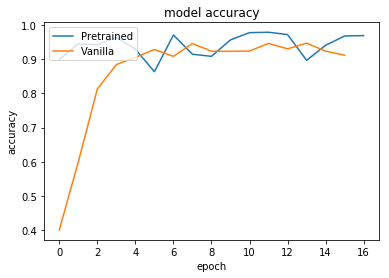

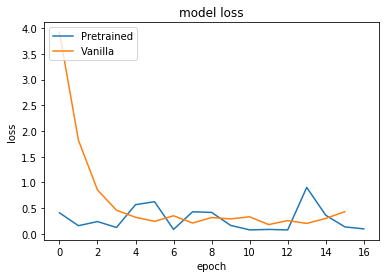

In [29]:
# summarize history for accuracy
plt.plot(history_pretrained.history['val_acc'])
plt.plot(history_vanilla.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Pretrained', 'Vanilla'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_pretrained.history['val_loss'])
plt.plot(history_vanilla.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Pretrained', 'Vanilla'], loc='upper left')
plt.show()

In [30]:
xception_transfer.load_weights("/tmp/saved_models/weights.best.xception_pretrained.hdf5")

In [31]:
xception_transfer_vanilla.load_weights("/tmp/saved_models/weights.best.xception_vanilla.hdf5")

In [32]:
xception_transfer.evaluate_generator(test_generator, test_generator.samples)

[0.10705800062605365, 0.968220797002234]

In [33]:
xception_transfer_vanilla.evaluate_generator(test_generator, test_generator.samples)

[0.08635824162688069, 0.9711032643943215]

**Part5: Testing on real test set**

In [34]:
def get_specific_class_img (class_name):
    root_directory = '../input/fruits/fruits-360_dataset/fruits-360/Training/'+ class_name + '/'
    img_path = glob.glob(os.path.join(root_directory,"*.jpg"))[0]
    return read_and_preprocess_img(img_path,"RGB",(100,100))

In [35]:
def model_predict(img,model_num):
    # obtain predicted vector
    if(model_num == "1"):
        predicted_vector = xception_transfer.predict(img)
    else:
        predicted_vector = xception_transfer_vanilla.predict(img)
    # return fruit class that is predicted by the model
    return x1[np.argmax(predicted_vector)]

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


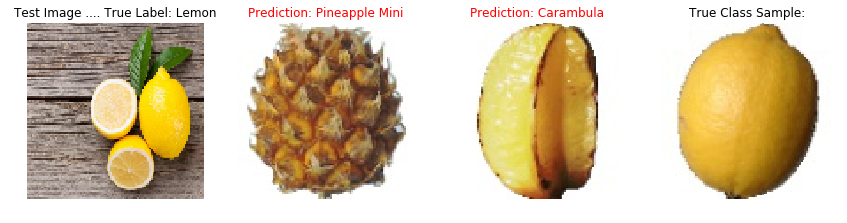

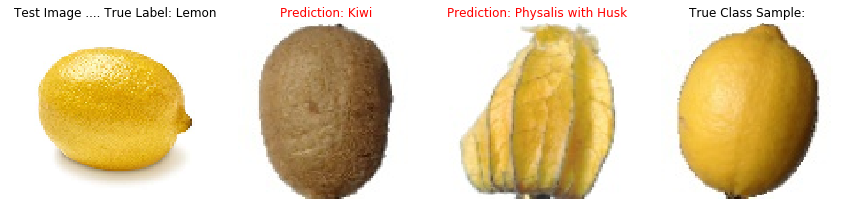

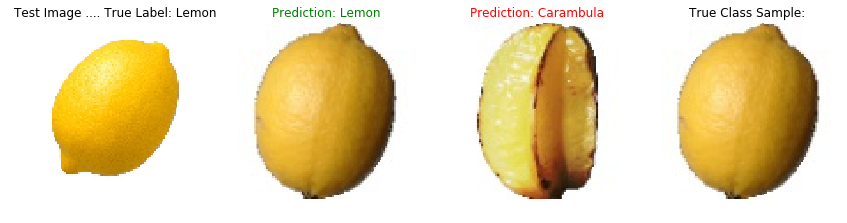

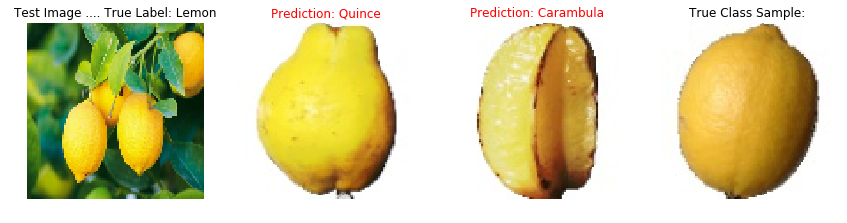

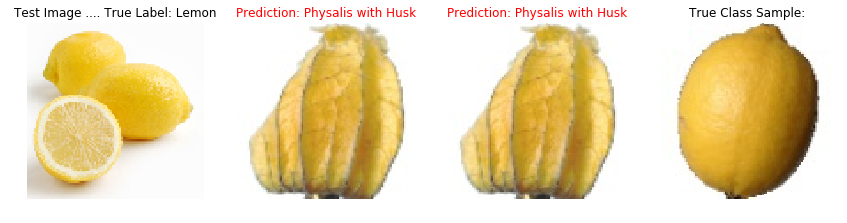

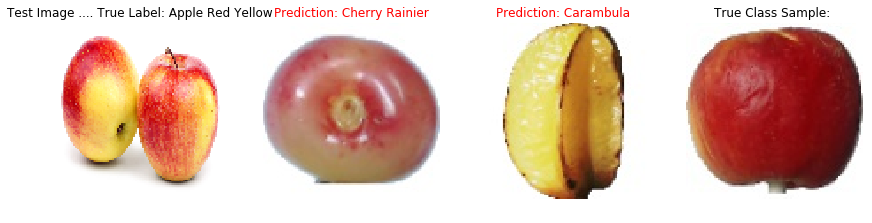

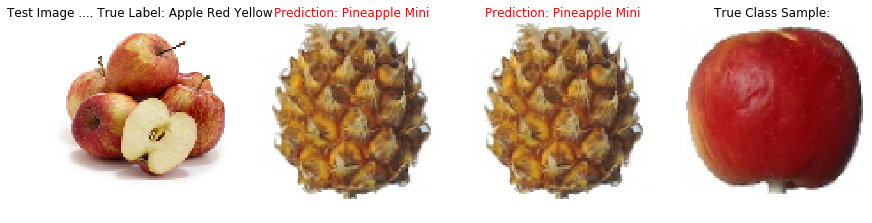

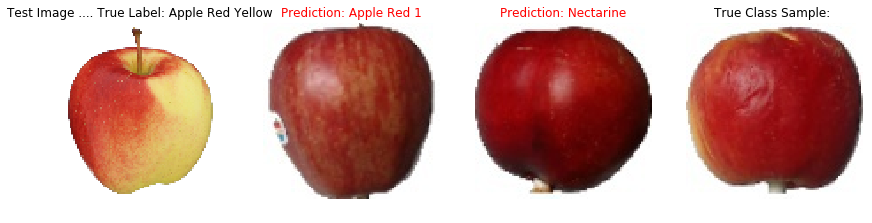

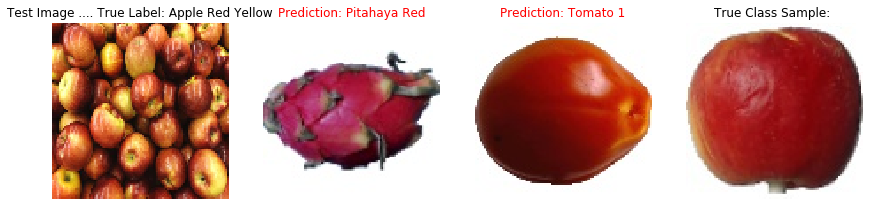

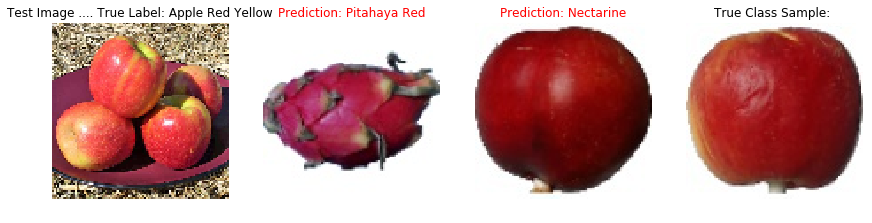

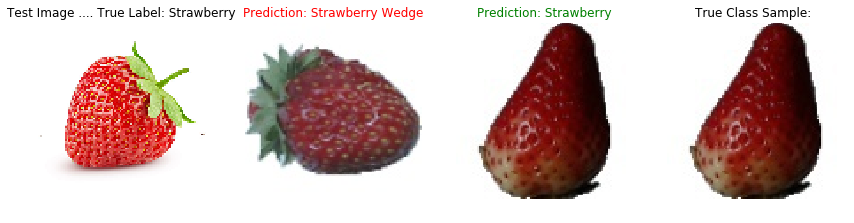

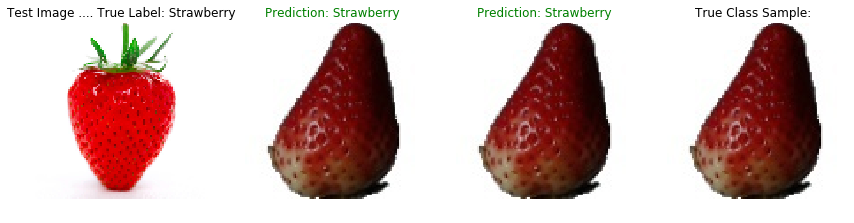

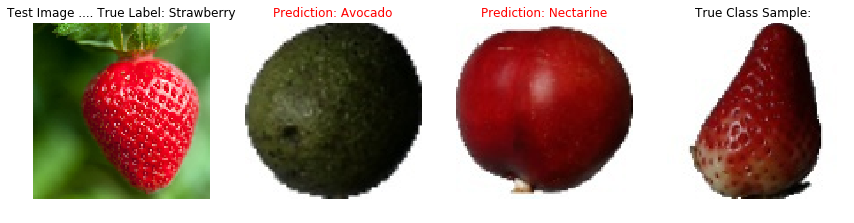

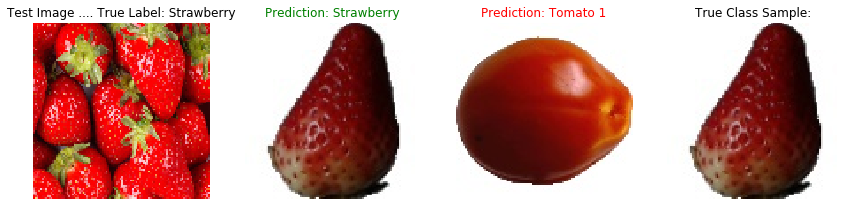

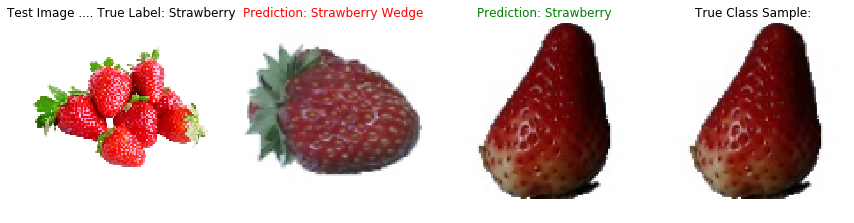

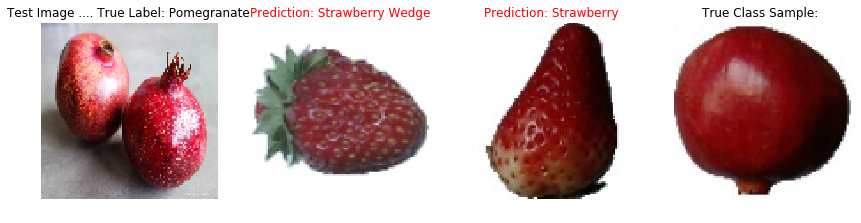

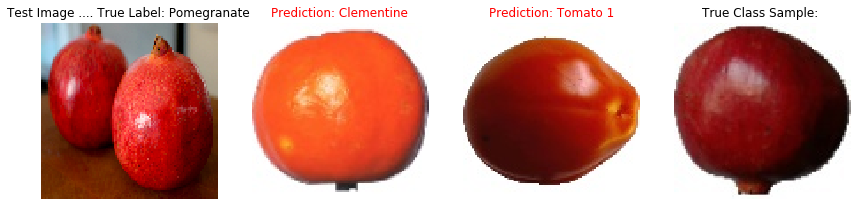

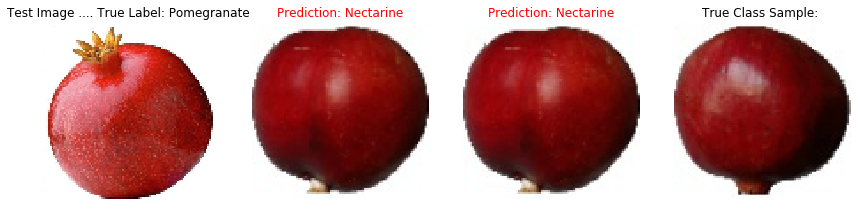

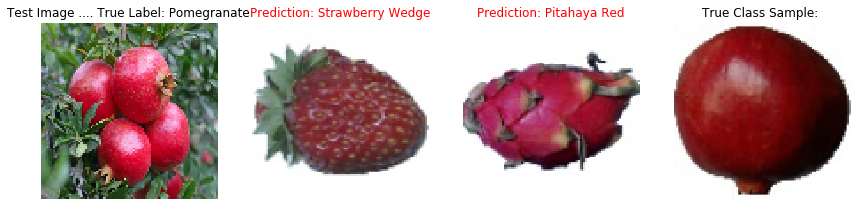

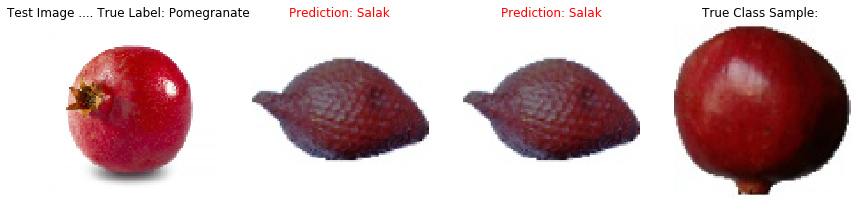

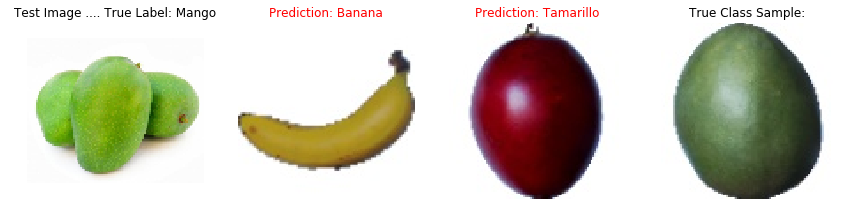

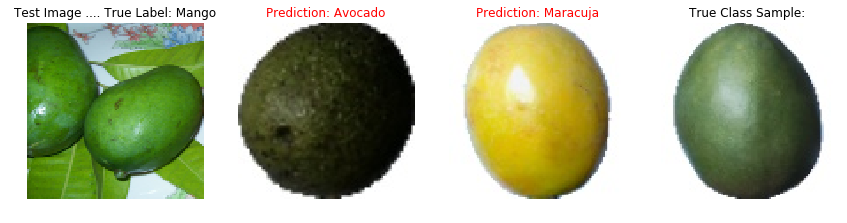

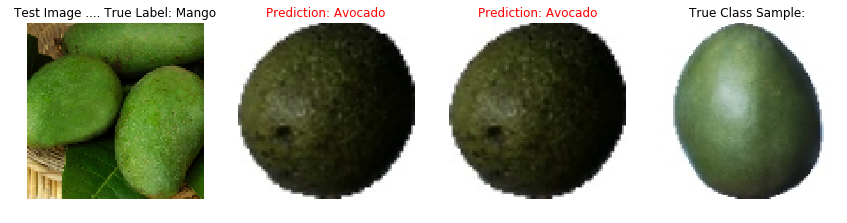

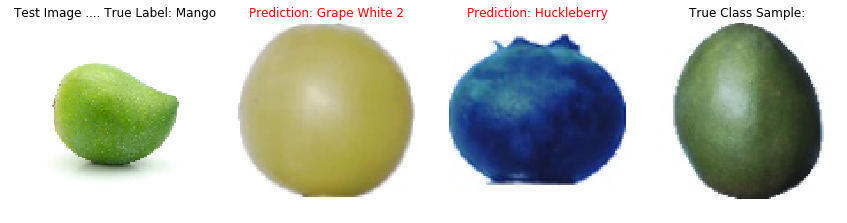

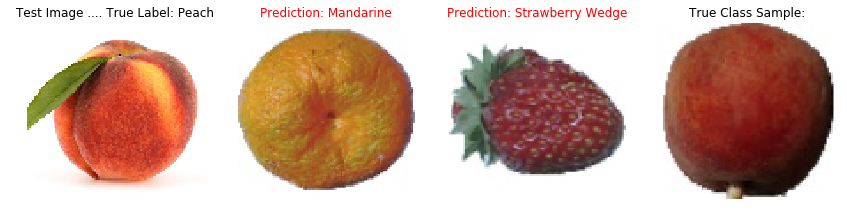

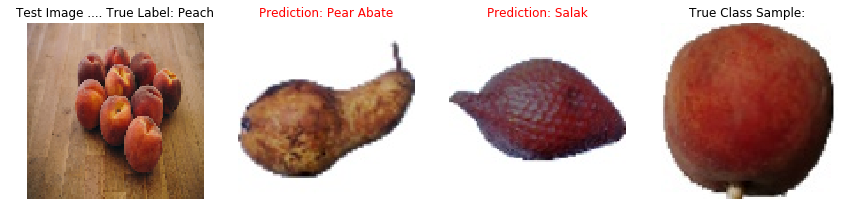

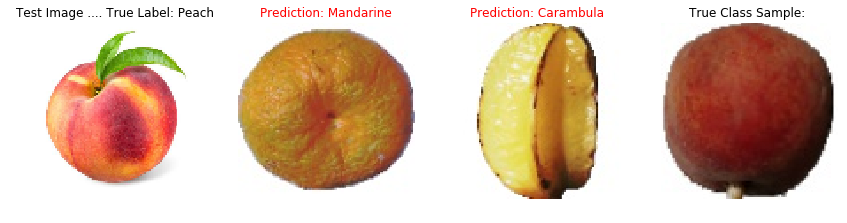

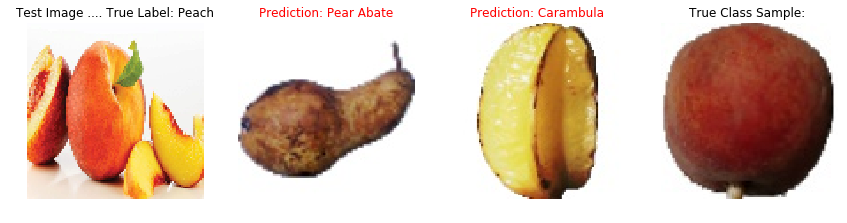

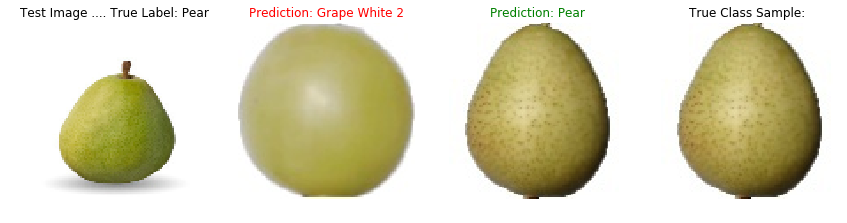

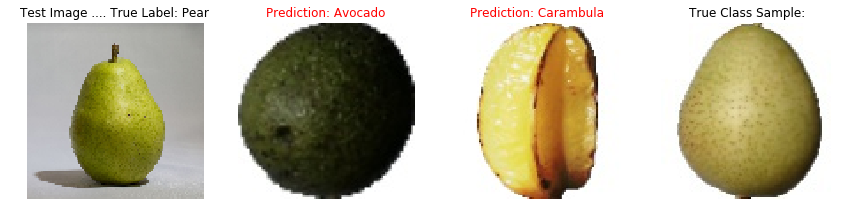

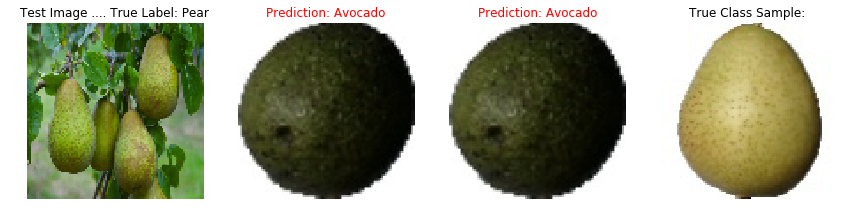

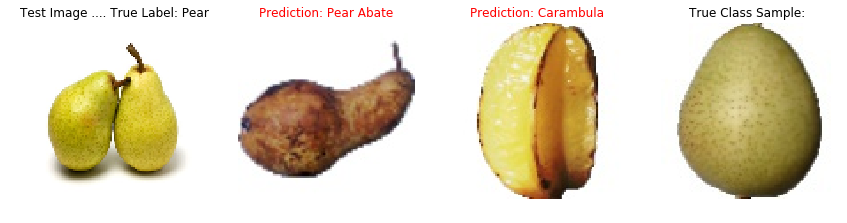

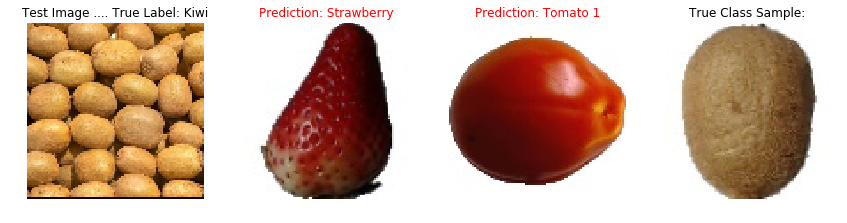

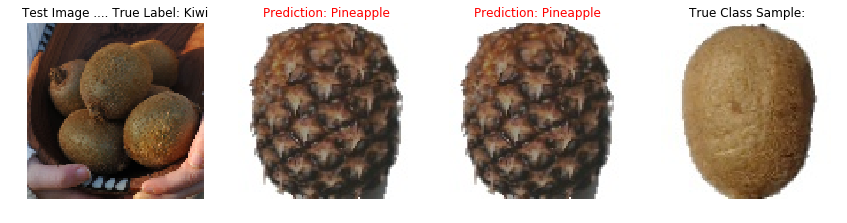

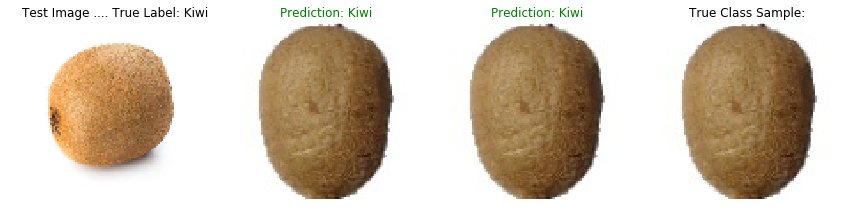

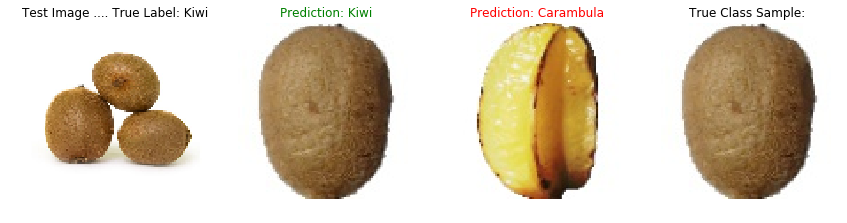

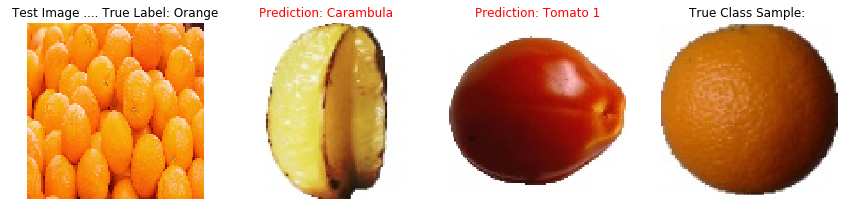

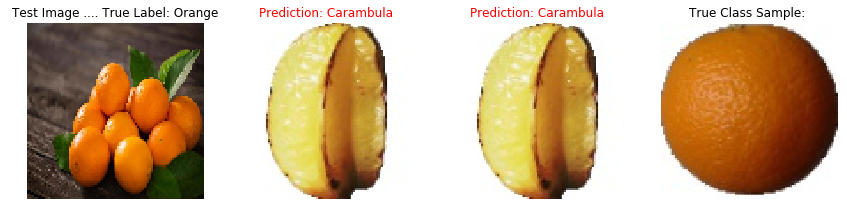

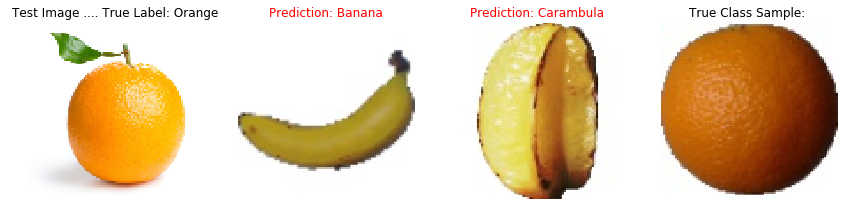

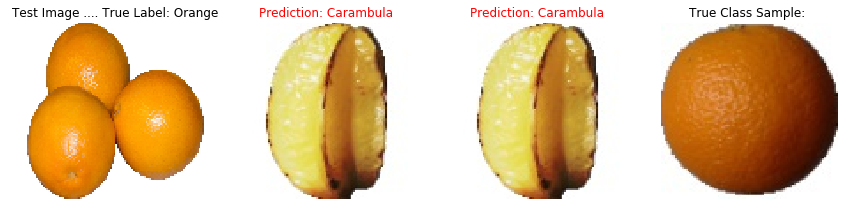

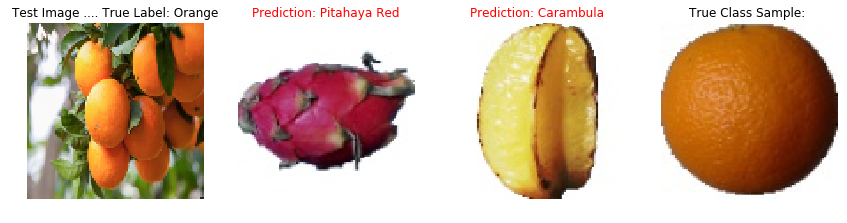

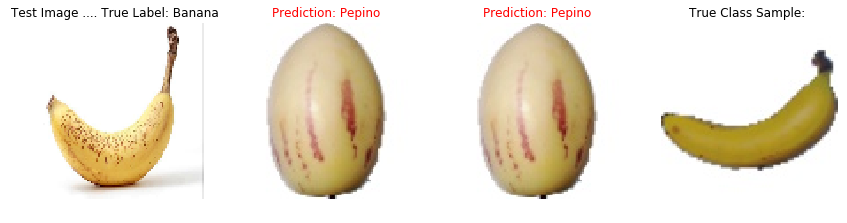

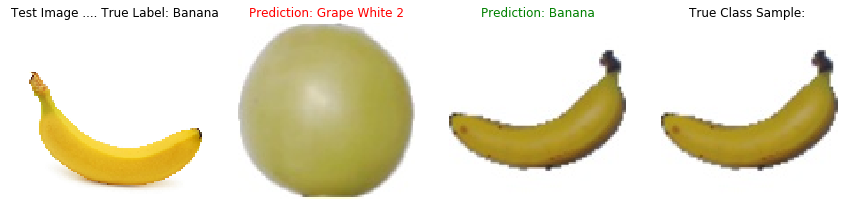

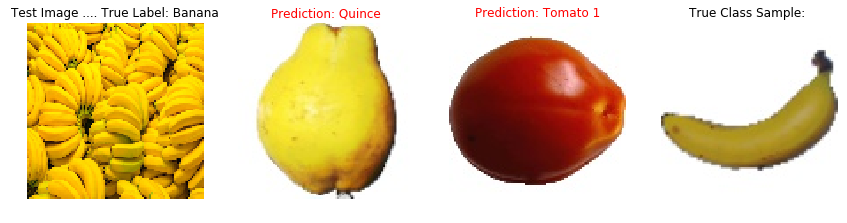

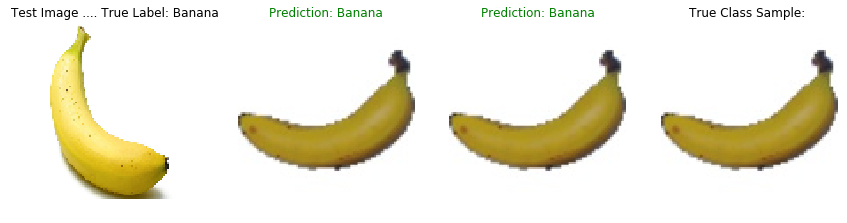

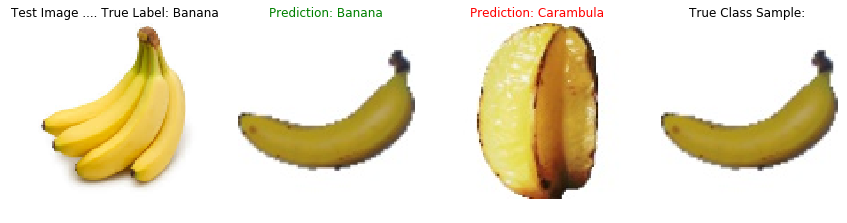

In [38]:
unseen_test_data_dir = '../input/realtestdata/real-data/Capstone Data/'
right_pred1 = 0
right_pred2 = 0
#unseen_test_data_dir = '../input/fruits/fruits-360_dataset/fruits-360/Test/'
X_real_test,test_label = read_data(unseen_test_data_dir,"RGB",(100,100))
for i,img in enumerate(X_real_test):
    pred_class_name1 = model_predict(np.expand_dims(img, axis=0),"1")
    pred_class_name2 = model_predict(np.expand_dims(img, axis=0),"2")
    true_label = test_label[i]
    pred_right1 = (true_label == pred_class_name1)
    pred_right2 = (true_label == pred_class_name2)

    if pred_right1:
        right_pred1 += 1
    if pred_right2:
        right_pred2 += 1
    f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4)
    plt.subplots_adjust(bottom=0.1, right=2, top=0.9)
    ax1.imshow(img)
    ax1.set_axis_off()    
    ax1.set_title('Test Image .... True Label: '+ true_label)
    ax2.imshow(get_specific_class_img(pred_class_name1))
    ax2.set_axis_off()
    ax2.set_title('Prediction: '+ pred_class_name1,color=("green" if pred_right1 else "red"))
    ax3.imshow(get_specific_class_img(pred_class_name2))
    ax3.set_axis_off()
    ax3.set_title('Prediction: '+ pred_class_name2,color=("green" if pred_right2 else "red"))
    ax4.imshow(get_specific_class_img(true_label))
    ax4.set_axis_off()
    ax4.set_title('True Class Sample: ')

In [39]:
print("Model 1 predicted {} images right,accuracy = {}%".format(right_pred1,(right_pred1*100./50)))
print("Model 2 predicted {} images right,accuracy = {}%".format(right_pred2,(right_pred2*100./50)))

Model 1 predicted 7 images right,accuracy = 14.0%
Model 2 predicted 7 images right,accuracy = 14.0%
